In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import layers
import keras_tuner as kt
from google.colab import drive
from keras.utils import to_categorical

In [2]:
def build_model_boston(hp):
    model = keras.Sequential()

    model.add(layers.Input(shape=(X_train.shape[1],)))

    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", min_value=16, max_value=256, step=16),
            activation=hp.Choice("activation", ["relu", "tanh"])
        ))

        if hp.Boolean(f"batch_norm_{i}"):
            model.add(layers.BatchNormalization())

        if hp.Boolean(f"dropout_{i}"):
            model.add(layers.Dropout(rate=hp.Float("dropout_rate", 0.1, 0.5, step=0.1)))

    model.add(layers.Dense(1))

    optimizer = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    return model

In [3]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/BostonHousing.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Mnist

In [8]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

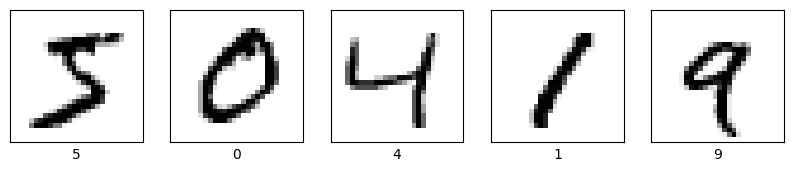

In [5]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

In [6]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_labels[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [15]:
model = keras.Sequential([
    layers.Flatten(),
    layers.Dense(256, activation='tanh'),
    layers.Dense(128, activation='tanh'),
    layers.Dense(64, activation='tanh'),
    #layers.BatchNormalization(),
    #layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels,
                    epochs=10,
                    batch_size=256,
                    validation_data=(test_images, test_labels)
                    )

test_loss, test_mae = model.evaluate(test_images, test_labels, verbose=2)
print('\nТестовая MAE:', test_mae)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8320 - loss: 0.5821 - val_accuracy: 0.9468 - val_loss: 0.1871
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9524 - loss: 0.1637 - val_accuracy: 0.9565 - val_loss: 0.1459
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9670 - loss: 0.1113 - val_accuracy: 0.9664 - val_loss: 0.1109
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9774 - loss: 0.0789 - val_accuracy: 0.9705 - val_loss: 0.0996
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9817 - loss: 0.0615 - val_accuracy: 0.9735 - val_loss: 0.0844
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9870 - loss: 0.0442 - val_accuracy: 0.9744 - val_loss: 0.0814
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9902 - loss: 0.0342 - val_accuracy: 0.9790 - val_loss: 0.0756
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9936 - loss: 0.0247 - val_accuracy: 0.977

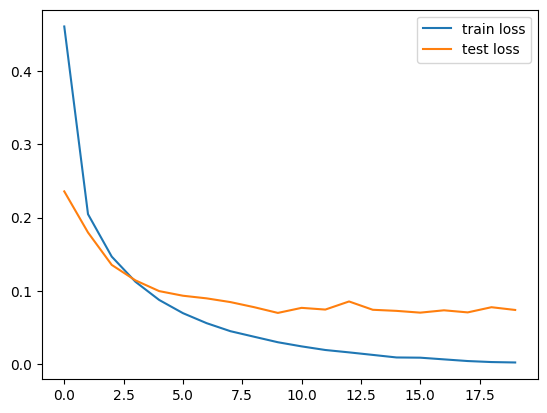

In [10]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

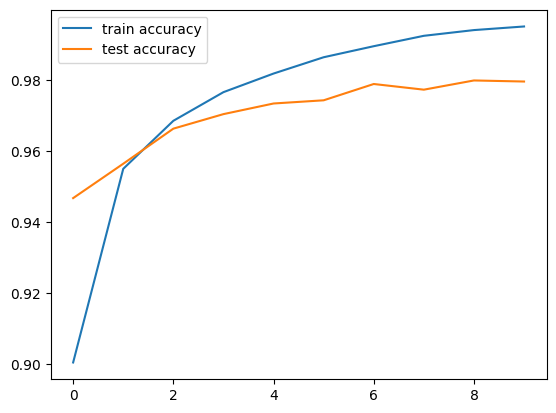

In [16]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend();

# Boston

In [12]:
X = df.iloc[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12]].values
y = df.iloc[:, 13].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=10)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [13]:
tuner = kt.RandomSearch(
    build_model_boston,
    objective="val_mae",
    max_trials=10,
    executions_per_trial=1,
    directory="keras_tuner",
    project_name="boston_housing"
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Лучшие гиперпараметры: {best_hps.values}")

best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, verbose=1)

loss, mae = best_model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

Reloading Tuner from keras_tuner/boston_housing/tuner0.json
Лучшие гиперпараметры: {'num_layers': 1, 'units_0': 224, 'activation': 'relu', 'batch_norm_0': True, 'dropout_0': True, 'optimizer': 'adam', 'units_1': 256, 'batch_norm_1': True, 'dropout_1': True, 'units_2': 128, 'batch_norm_2': False, 'dropout_2': False, 'dropout_rate': 0.4}
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 540.7142 - mae: 21.5539 - val_loss: 731.3675 - val_mae: 25.1849
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 517.6734 - mae: 21.5828 - val_loss: 713.2603 - val_mae: 24.9375
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 503.8229 - mae: 21.3873 - val_loss: 695.4287 - val_mae: 24.6686
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 450.2065 - mae: 20.4355 - val_loss: 677.6622 - val_mae: 24.3795
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 466.0961 - mae: 20.9026 - val_loss: 659.0674 - val_mae: 24.0557
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [24]:
model = keras.Sequential([
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_test, y_test)
                    )

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=2)
print('\nТестовая MAE:', test_mae)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 578.7800 - mae: 22.1923 - val_loss: 730.9772 - val_mae: 25.0932
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 530.1255 - mae: 21.7296 - val_loss: 720.6728 - val_mae: 24.9713
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 516.3502 - mae: 21.6483 - val_loss: 710.8248 - val_mae: 24.8421
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 498.3229 - mae: 21.4774 - val_loss: 701.3303 - val_mae: 24.7034
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 490.5959 - mae: 21.3441 - val_loss: 692.0087 - val_mae: 24.5579
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 487.5764 - mae: 21.3077 - val_loss: 682.4204 - val_mae: 24.4005
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 461.7756 - mae: 20.8700 - val_loss: 672.3259 - val_mae: 24.2299
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 436.0076 - mae: 20.2914 - val_loss: 661.7881 - val_mae: 24.0415
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━

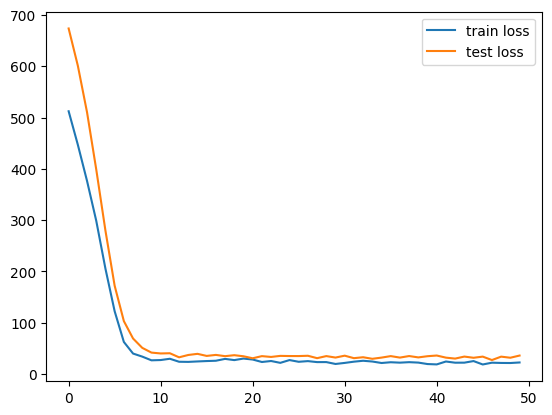

In [19]:
#batch_size = 8

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

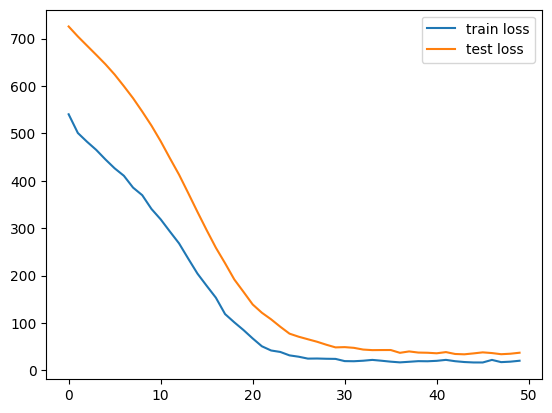

In [21]:
#batch_size = 32

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

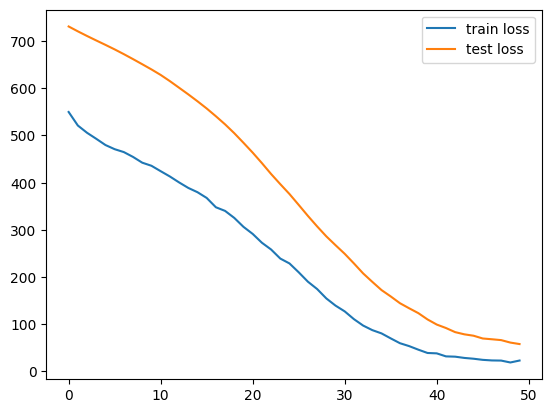

In [25]:
#batch_size = 64

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

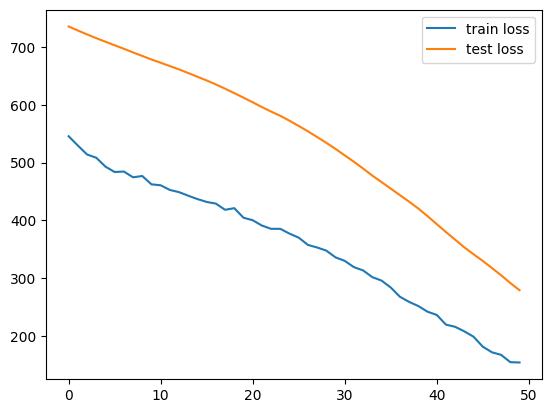

In [23]:
#batch_size = 128

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();